In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from tqdm import tqdm
from rdkit.Chem import Descriptors, rdmolops, AllChem
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from scripts.utils.data_utils import LigandDataset

In [2]:
with open('data/filtered_labels_smiles.pkl', 'rb') as f:
    filtered_labels = pickle.load(f)
with open('data/filtered_mol_ls_smiles.pkl', 'rb') as f:
    filtered_mol_ls = pickle.load(f)

print(len(filtered_labels))

46719


# Predicting Denticity by Electronegative Atoms

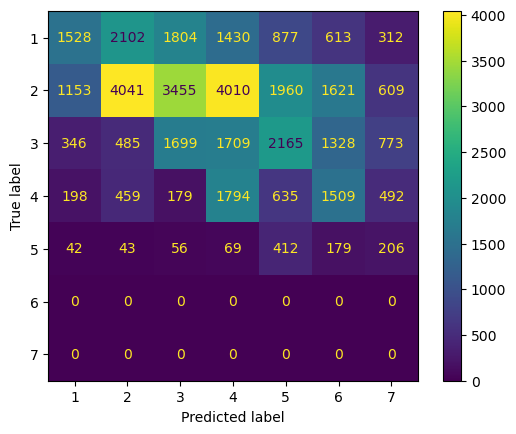

In [3]:
true_denticities = [sum(label) for label in filtered_labels]
common_catoms = [7, 8, 9, 17, 35, 53]
pred_denticities = [len([a.GetAtomicNum() for a in ligand.GetAtoms() if a.GetAtomicNum() in common_catoms])
                    for ligand in filtered_mol_ls]

cm = confusion_matrix(true_denticities, pred_denticities, labels=np.arange(1, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, 8))
disp.plot()
plt.savefig('figures/electronegativity_denticity_cm.png', dpi=300)

In [4]:
num_correct = 0

for i in range(len(true_denticities)):
    true = true_denticities[i]
    pred = pred_denticities[i]

    if true == pred:
        num_correct += 1

frac_correct = num_correct / len(true_denticities)
print(f'The fraction of structures that have their denticity predicted correctly is {frac_correct:1.3f}.')

The fraction of structures that have their denticity predicted correctly is 0.203.


## Predicting all Atoms

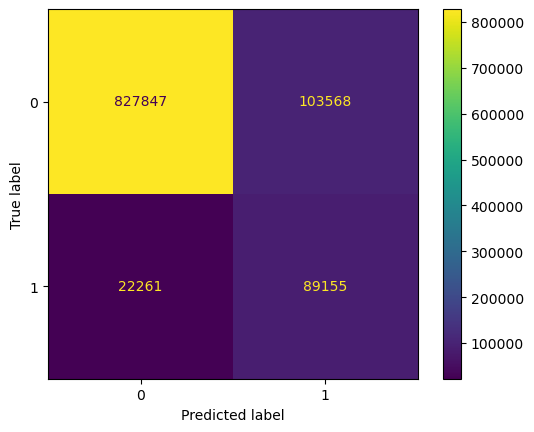

In [5]:
true_labels = np.concatenate(filtered_labels)
atom_list = np.concatenate([[a.GetAtomicNum() for a in ligand.GetAtoms()] for ligand in filtered_mol_ls])
heur_labels = []
for atom in atom_list:
    if atom in common_catoms:
        heur_labels.append(1)
    else:
        heur_labels.append(0)

cm = confusion_matrix(true_labels, heur_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d')
plt.savefig('figures/electronegativity_allatoms_cm.png', dpi=300)

In [6]:
num_correct = 0

for i in range(len(true_labels)):
    true = true_labels[i]
    pred = heur_labels[i]

    if true == pred:
        num_correct += 1

frac_correct = num_correct / len(true_labels)
print(f'The fraction of atoms that have their coordination predicted correctly is {frac_correct:1.3f}.')

The fraction of atoms that have their coordination predicted correctly is 0.879.


## Test Set

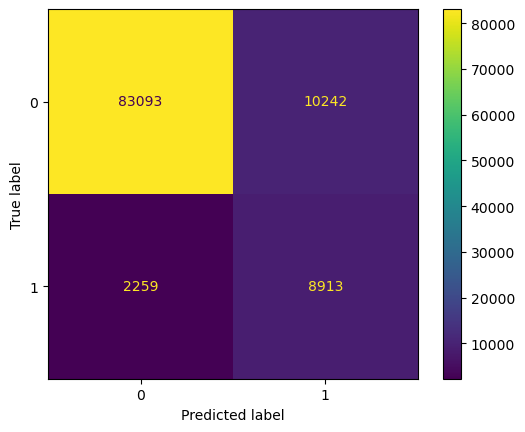

In [7]:
#on the test set
test = torch.load('data/reproduced_test_dataset_smiles.pt')

mol_ls = []
labels = []

for data in test:
    mol_ls.append(Chem.MolFromSmiles(data.smiles))
    labels.append(np.array(data.y))

true_labels = np.concatenate(labels)
atom_list = np.concatenate([[a.GetAtomicNum() for a in ligand.GetAtoms()] for ligand in mol_ls])
heur_labels = []
for atom in atom_list:
    if atom in common_catoms:
        heur_labels.append(1)
    else:
        heur_labels.append(0)

cm = confusion_matrix(true_labels, heur_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d')
plt.savefig('figures/testset-electronegativity_denticity_cm.png', dpi=300)

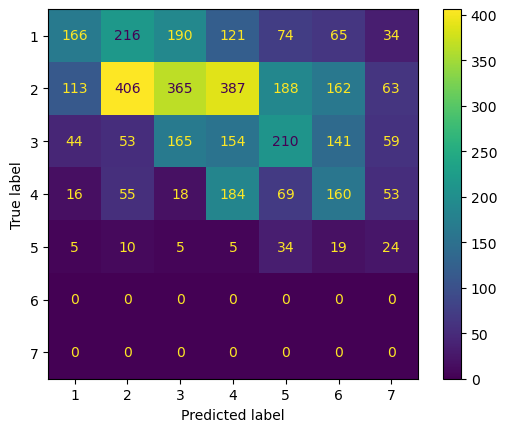

In [8]:
true_denticities = []
pred_denticities = []

for data in test:
    ligand = Chem.MolFromSmiles(data.smiles)
    pred_denticities.append(len([a.GetAtomicNum() for a in ligand.GetAtoms() if a.GetAtomicNum() in common_catoms]))
    true_denticities.append(sum(np.array(data.y)))
 
cm = confusion_matrix(true_denticities, pred_denticities, labels=np.arange(1, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, 8))
disp.plot()
plt.savefig('figures/testset-electronegativity_allatoms_cm.png', dpi=300)

# Predicting Denticity with Partial Charge

In [9]:
charge_list = []
label_list = []

for idx, mol in tqdm(enumerate(filtered_mol_ls), total=len(filtered_mol_ls)):
    try:
        molec_props = Chem.AllChem.MMFFGetMoleculeProperties(rdmolops.AddHs(mol))
    except:
        continue
    if molec_props:
        charges = np.array([molec_props.GetMMFFPartialCharge(i) for i, _ in enumerate(mol.GetAtoms())])
        charge_list.append(charges)
        label_list.append(filtered_labels[idx])
    else:
        pass
        '''
        print("MMFF charges not available for the input molecule, defaulting to Gasteiger charges.")
        AllChem.ComputeGasteigerCharges(mol)
        charges=np.array([a.GetDoubleProp('_GasteigerCharge') for a in mol.GetAtoms()])
        '''

100%|██████████| 46719/46719 [00:07<00:00, 6331.41it/s]


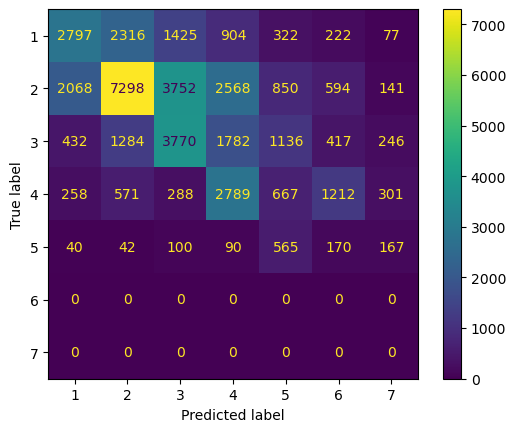

In [10]:
true_denticities = [sum(label) for label in label_list]
pred_denticities = [len(np.where(charges < -0.5)[0]) for charges in charge_list]

cm = confusion_matrix(true_denticities, pred_denticities, labels=np.arange(1, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, 8))
disp.plot()
plt.savefig('figures/partialcharge_denticity_cm.png', dpi=300)

In [11]:
num_correct = 0

for i in range(len(true_denticities)):
    true = true_denticities[i]
    pred = pred_denticities[i]

    if true == pred:
        num_correct += 1

frac_correct = num_correct / len(true_denticities)
print(f'The fraction of structures that have their denticity predicted correctly is {frac_correct:1.3f}.')

The fraction of structures that have their denticity predicted correctly is 0.369.


100%|██████████| 46719/46719 [00:07<00:00, 6336.88it/s]


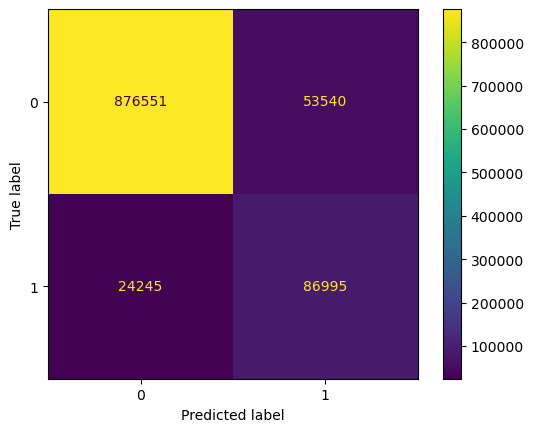

In [12]:
#Predicting on all atoms

charge_list = []
label_list = []

for idx, mol in tqdm(enumerate(filtered_mol_ls), total=len(filtered_mol_ls)):
    try:
        molec_props = Chem.AllChem.MMFFGetMoleculeProperties(rdmolops.AddHs(mol))
    except:
        continue
    if molec_props:
        charges = np.array([molec_props.GetMMFFPartialCharge(i) for i, _ in enumerate(mol.GetAtoms())])
        charge_list.append(charges)
        label_list.append(filtered_labels[idx])
    else:
        pass

true_labels = np.concatenate(label_list)
heur_labels = np.concatenate([charges < -0.5 for charges in charge_list])

cm = confusion_matrix(true_labels, heur_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d')
plt.savefig('figures/partialcharge_allatoms_cm.png', dpi=300)

## Test Set

100%|██████████| 4668/4668 [00:00<00:00, 6210.42it/s]


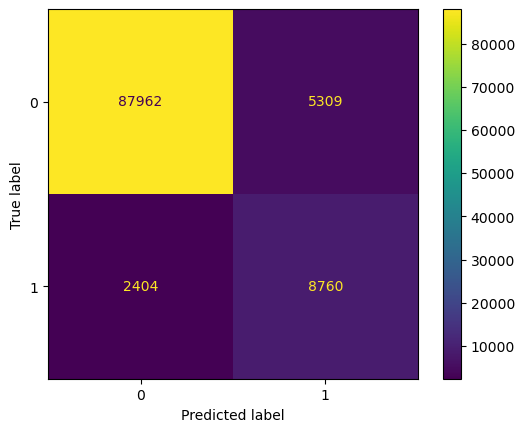

In [13]:
#on the test set
test = torch.load('data/reproduced_test_dataset_smiles.pt')

mol_ls = []
labels = []

for data in test:
    mol_ls.append(Chem.MolFromSmiles(data.smiles))
    labels.append(np.array(data.y))

label_list = []
charge_list = []

for idx, mol in tqdm(enumerate(mol_ls), total=len(mol_ls)):
    try:
        molec_props = Chem.AllChem.MMFFGetMoleculeProperties(rdmolops.AddHs(mol))
    except:
        continue
    if molec_props:
        charges = np.array([molec_props.GetMMFFPartialCharge(i) for i, _ in enumerate(mol.GetAtoms())])
        charge_list.append(charges)
        label_list.append(labels[idx])
    else:
        pass

true_labels = np.concatenate(label_list)
heur_labels = np.concatenate([charges < -0.5 for charges in charge_list])

cm = confusion_matrix(true_labels, heur_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d')
plt.savefig('figures/testset-partialcharge_allatoms_cm.png', dpi=300)

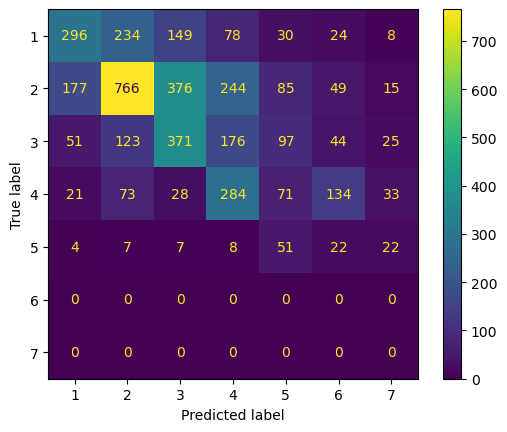

In [14]:
true_denticities = []
pred_denticities = []

for data in test:
    mol = Chem.MolFromSmiles(data.smiles)
    try:
        molec_props = Chem.AllChem.MMFFGetMoleculeProperties(rdmolops.AddHs(mol))
    except:
        continue
    if molec_props:
        charges = np.array([molec_props.GetMMFFPartialCharge(i) for i, _ in enumerate(mol.GetAtoms())])
        pred_denticities.append(sum(charges<-0.5))
        true_denticities.append(float(data.denticity))
    else:
        pass
 
cm = confusion_matrix(true_denticities, pred_denticities, labels=np.arange(1, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, 8))
disp.plot()
plt.savefig('figures/testset-partialcharge_denticity_cm.png', dpi=300)